In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import segmentation_models_pytorch as smp
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import rasterio

Prepare and Preprocess

- define device
- load models you want to compare
- Load the testing data
- predict on every image/model and store the results in a pandas dataframe


In [ ]:
# define a device, so we can delegate computations to the gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
"""
We trained 5 models with resnet34 encoder and again with efficientnet-b4.
Here we are initializing the models we want to evaluate and compare. 
Some combinations are suggested down below. To check other combinations, 
just throw the models into a dir and pass the path to the init_models function (follow the naming convention)
"""

models= {}

def init_models(model_dir):
    model_names = sorted(os.listdir(model_dir))
    
    for m in model_names:
        name = m.removesuffix(".pth")
        if("_enetb4") in name:
            n = name.removesuffix("_enetb4")
            smpmodel = getattr(smp, n)
            model = smpmodel(
                encoder_name = 'efficientnet-b4',
                encoder_weights = None,
                in_channels = 4,
                classes = 1,
                activation='sigmoid'
            ).to(device)
        else:
            smpmodel = getattr(smp, name)
            model = smpmodel(
                encoder_name = 'resnet34',
                encoder_weights = None,
                in_channels = 4,
                classes = 1,
                activation='sigmoid'
            ).to(device)
        state_dict = torch.load(os.path.join(model_dir, m), map_location=device)
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        models[name] = model

#init_models("./final_models/resnet34")
#init_models("./final_models/enetb4")
#init_models("./final_models/deeplabv3")
#init_models("./final_models/unet")
#init_models("./final_models/unetplusplus")
#init_models("./final_models/fpn")
init_models("./final_models/pan")

In [ ]:
eval_root=".data/AMAZON/Test"

In [ ]:
"""
Here we load the data to evaluate on. 
We ensured that the data is normalized the same way it was for the training, so this is nearly
the code as in the training Notebook
"""

mean = torch.tensor([0.485, 0.456, 0.406, 0.5])
std  = torch.tensor([0.229, 0.224, 0.225, 0.5])
preprocess = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])
# Binary for mask (It's always 0 or 1)
mask_preprocess = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

class EvalDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_tranform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'image')
        self.mask_dir = os.path.join(root_dir, 'label')

        self.image_names = sorted(os.listdir(self.image_dir))
        self.mask_names = sorted(os.listdir(self.mask_dir))

        # Add a check here to ensure #image and #mask are equal
        print(len(self.image_names), len(self.mask_names))
        if len(self.image_names) != len(self.mask_names):
            raise ValueError("Number of images and masks do not match.")

        # check that mask- and image name correspond to each other
        # otherwise throw an error
        for i in range(len(self.image_names)):
            img_base = os.path.splitext(self.image_names[i])[0]
            mask_base = os.path.splitext(self.mask_names[i])[0]
            if img_base != mask_base:
                print(f"Warning: Image '{self.image_names[i]}' and mask '{self.mask_names[i]}' have different base names. Ensure they correspond correctly.")
        self.transform = transform
        self.mask_transform = mask_tranform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.image_names[index])
        mask_path = os.path.join(self.mask_dir, self.mask_names[index])
        with rasterio.open(image_path) as src:
            image = src.read()  # (C, H, W)
        
        # Normalize
        #image = torch.from_numpy(image).float()
        image = (image / 10000*255).astype(np.uint8)
        image = np.moveaxis(image, 0, -1)
        image = self.transform(Image.fromarray(image))
        
        with rasterio.open(mask_path) as src: 
            mask = src.read()
        mask = mask.astype(np.float32).squeeze(0)
        mask = Image.fromarray(mask)
        mask = self.mask_transform(mask)
        mask = (mask > 0).long()
        return image, mask
    
evaldata = EvalDataset(eval_root, preprocess, mask_preprocess)
evalloader = DataLoader(evaldata, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

20 20


In [ ]:
"""
Very simpel predict function
"""
def predict (model, img):
    model.eval()
    with torch.no_grad():
        pred = model(img.to(device))
    pred = pred.cpu().squeeze(0).numpy()
    return pred

In [ ]:
"""
In this function we compute some metrices of every model - image pair for evaluation and comparison. 
The metrices are calculated based on the confusion matrix and returned in a dictionary.
"""

def calculate_metrics(pred, gt):
    
    pred = pred.squeeze()
    pred = torch.from_numpy(pred)
    pred = (pred > 0.5).long()
    
    gt = gt.squeeze()

    tp = ((pred==1) & (gt==1)).sum().float()
    fp = ((pred==1) & (gt==0)).sum().float()
    fn = ((pred==0) & (gt==1)).sum().float()
    tn = ((pred==0) & (gt==0)).sum().float()

    iou = tp / (tp + fp + fn + 1e-6)
    dice = 2*tp / (2*tp + fp + fn + 1e-6)
    acc = (pred == gt).float().mean()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    return {
        "tp": tp.item(),
        "fp": fp.item(),
        "fn": fn.item(),
        "tn": tn.item(),
        "iou": iou.item(),
        "dice": dice.item(),
        "acc": acc.item(),
        "precision": precision.item(),
        "recall": recall.item(),
    }


In [ ]:
"""
Here we predict a mask to every image of the dataset with every model. 
The predicts and computed metrices are stored in a pandas dataframe, 
so they can be accessed an processed easily later on.
"""

import pandas as pd
rows = []
for model_name, model in models.items():
    for idx, (img, mask) in enumerate(evalloader):
        pred = predict(model, img)
        metrics = calculate_metrics(pred, mask)

        row = {
            "model": model_name,
            "image_idx": idx,
            **metrics,  # expand dict
            "mask": pred
        }
        rows.append(row)

df = pd.DataFrame(rows)

Plotting

here begins the plotting of the metrices


     model      iou     dice      acc  precision   recall
       PAN 0.819558 0.877788 0.942697   0.853692 0.904141
PAN_enetb4 0.803407 0.868072 0.894142   0.840125 0.899339


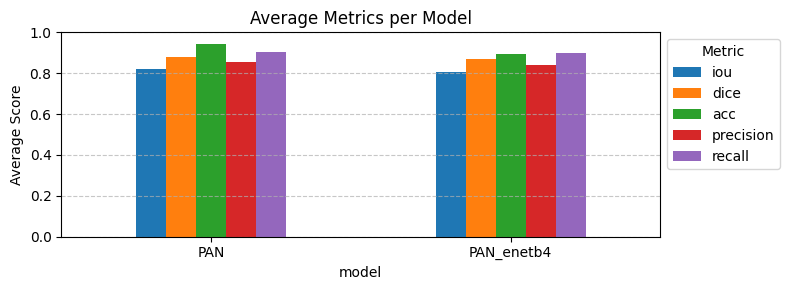

In [ ]:
"""
Here we compute the mean of the IoU, Dice, Accuracy, Precision and Recall per model.
This will be plotted to compare the overall performance of the models
"""

def plot_average_metrics(df, metrics=None):
  
    if metrics is None:
        metrics = ["iou", "dice", "acc", "precision", "recall"]

    # Mittelwert pro Modell berechnen
    mean_df = df.groupby("model")[metrics].mean().reset_index()
    print(mean_df.to_string(index=False))
    # Balkendiagramm plotten
    mean_df.plot(x="model", y=metrics, kind="bar", figsize=(8,3), rot=0)
    plt.ylim(0, 1)
    plt.ylabel("Average Score")
    plt.title("Average Metrics per Model")
    plt.legend(title="Metric",loc="best", bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_average_metrics(df)

/tmp/ipykernel_508/1894999132.py:57: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=c_tn, edgecolor='black', label='TN (richtig negativ)')
/tmp/ipykernel_508/1894999132.py:114: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[1,1,1,1])


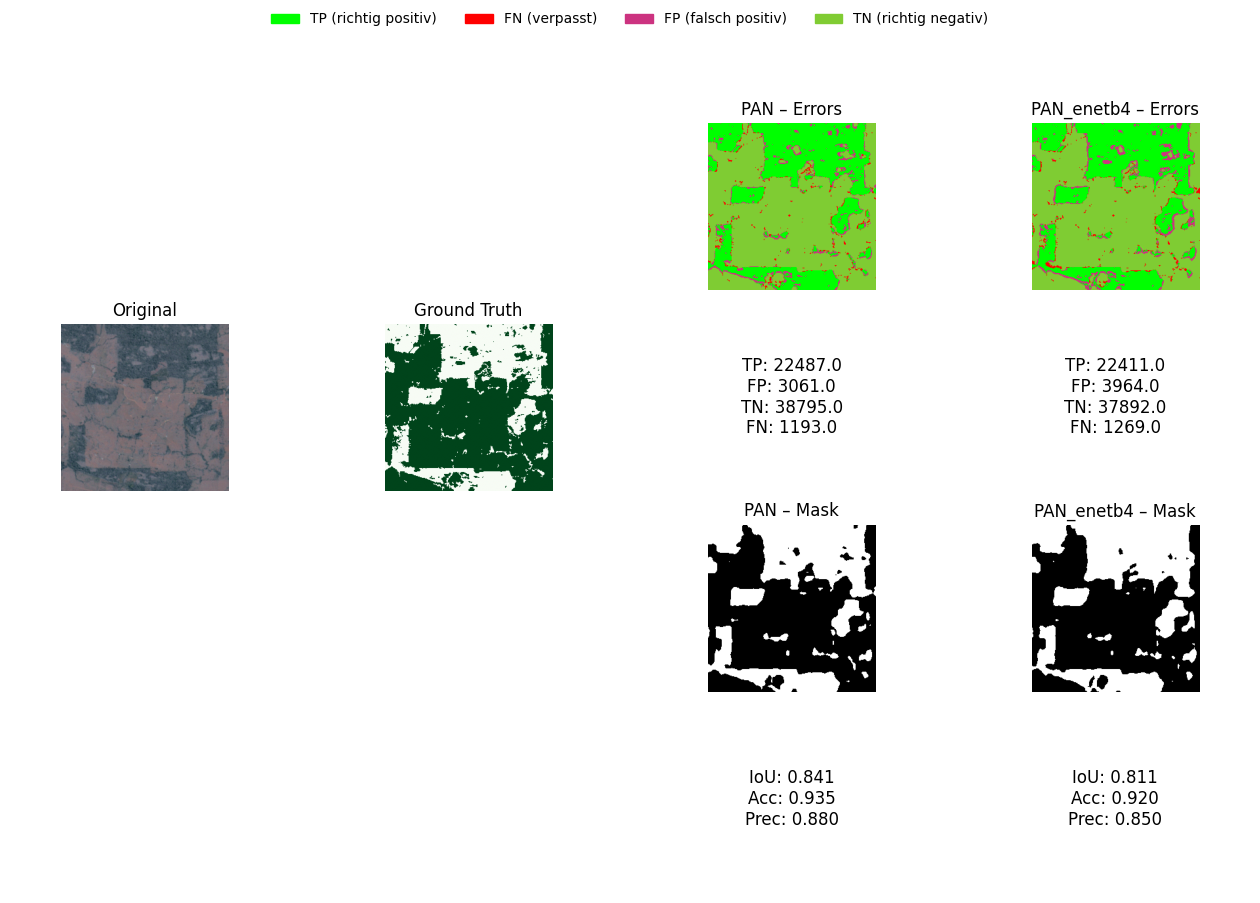

In [ ]:
"""
Here we will plot one mask as Heatmap per model for a given image (addressed over index)
The Heatmap shows where True Positives, False Positives, True Negatives and False Negatives are. 

This helps to find out strength and weaknesses of the models (eg who performs best on fine structures)
"""

def plot_image_comparison(df, dataloader, image_idx):

    img, gt = None, None
    for idx, (i, m) in enumerate(dataloader):
        if idx == image_idx:
            img = i
            gt = m
            break
    if img is None:
        raise ValueError(f"Image index {image_idx} not found")

    # Originalbild für Plot
    img_plot = img.squeeze().cpu().numpy()
    img_plot = np.transpose(img_plot, (1,2,0))
    img_plot = (img_plot - img_plot.min()) / (img_plot.max() - img_plot.min() + 1e-8)

    gt = gt.squeeze().cpu().numpy()

    df_img = df[df["image_idx"] == image_idx]
    models = df_img["model"].unique()
    n_models = len(models)

    fig, axes = plt.subplots(4, n_models + 2, figsize=(4*(n_models+2), 10))

    axes[1,0].imshow(img_plot)
    axes[1,0].set_title("Original")
    axes[1,0].axis("off")

    axes[1,1].imshow(gt, cmap="Greens_r")
    axes[1,1].set_title("Ground Truth")
    axes[1,1].axis("off")

    axes[0,0].axis("off")
    axes[0,1].axis("off")
    axes[2,0].axis("off")
    axes[2,1].axis("off")
    axes[3,0].axis("off")
    axes[3,1].axis("off")


    c_tp = [0,1,0]
    c_fn = [1,0,0] 
    c_fp = [0.8,0.2,0.5]
    c_tn = [0.5,0.8,0.2]  

    legend_elements = [
    mpatches.Patch(color=c_tp , label='TP (richtig positiv)'),
    mpatches.Patch(color=c_fn, label='FN (verpasst)'),
    mpatches.Patch(color=c_fp, label='FP (falsch positiv)'),
    mpatches.Patch(color=c_tn, edgecolor='black', label='TN (richtig negativ)')
    ]
    fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=4,
        frameon=False
    )
    axes[1,1].legend

    for col, model_name in enumerate(models, start=2):
        row = df_img[df_img["model"] == model_name].iloc[0]

        pred = np.array(row["mask"])
        pred_bin = (pred > 0.5).astype(np.uint8)
        pred_bin = pred_bin.squeeze(0)
        heatmap = np.ones((*pred_bin.shape, 3), dtype=np.float32)

        """
        Here we calculate the matrixes, to find out where our model was right/wrong
        """
        tp = (pred_bin == 1) & (gt == 1)
        fn = (pred_bin == 0) & (gt == 1)
        fp = (pred_bin == 1) & (gt == 0)
        tn = (pred_bin == 0) & (gt == 0)


        heatmap[tp] = c_tp       
        heatmap[fn] = c_fn  
        heatmap[fp] = c_fp
        heatmap[tn] = c_tn

        axes[2,col].imshow(pred_bin, cmap="gray")
        axes[2,col].set_title(f"{model_name} – Mask")
        axes[2,col].axis("off")

        axes[0,col].imshow(heatmap)
        axes[0,col].set_title(f"{model_name} – Errors")
        axes[0,col].axis("off")

        cm = (
            f"TP: {row.tp}\n"
            f"FP: {row.fp}\n"
            f"TN: {row.tn}\n"
            f"FN: {row.fn}\n"
        )
        axes[1,col].text(0.5, 0.5, cm, ha="center", va="center", fontsize=12)
        axes[1,col].axis("off")

        metrics_text = (
            f"IoU: {row.iou:.3f}\n"
            f"Acc: {row.acc:.3f}\n"
            f"Prec: {row.precision:.3f}\n"
        )
        axes[3,col].text(0.5, 0.5, metrics_text, ha="center", va="center", fontsize=12)
        axes[3,col].axis("off")
    
    plt.tight_layout(rect=[1,1,1,1])
    plt.show()

plot_image_comparison(df, evalloader, 15)

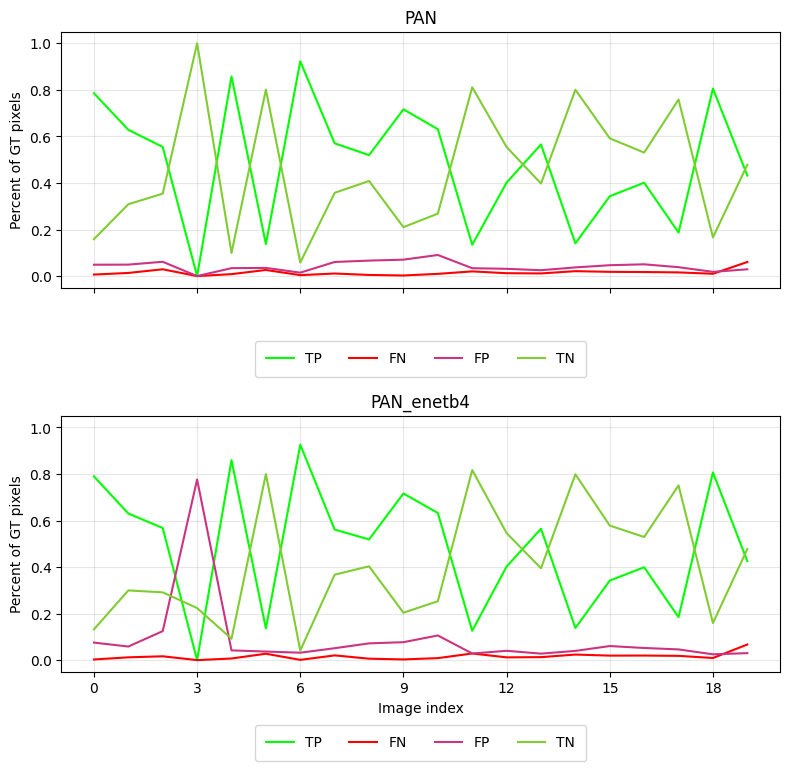

In [ ]:
"""
And here we are calculating the values of the confusion-matrix in percentage. 
"""

def plot_confusion_metrics_per_image(df):

    # Farbschema
    c_tp = [0,1,0]
    c_fn = [1,0,0]
    c_fp = [0.8,0.2,0.5]
    c_tn = [0.5,0.8,0.2]

    models = df["model"].unique()
    n_models = len(models)

    fig, axes = plt.subplots(
        n_models, 1, figsize=(8, 4*n_models), sharex=True
    )

    if n_models == 1:
        axes = [axes]

    for ax, model in zip(axes, models):
        d = df[df["model"] == model].sort_values("image_idx")
        

        total_pixels = d["tp"] + d["fn"] + d["fp"] + d["tn"]

        # Calculate percentage of total_pixels
        tp_pct = d["tp"] / total_pixels
        fn_pct = d["fn"] / total_pixels
        fp_pct = d["fp"] / total_pixels
        tn_pct = d["tn"] / total_pixels

        ax.plot(d["image_idx"], tp_pct, label="TP", color=c_tp)
        ax.plot(d["image_idx"], fn_pct, label="FN", color=c_fn)
        ax.plot(d["image_idx"], fp_pct, label="FP", color=c_fp)
        ax.plot(d["image_idx"], tn_pct, label="TN", color=c_tn)
        ax.set_ylim(-0.05, 1.05)

        ax.set_title(model)
        ax.set_ylabel("Percent of GT pixels")
        ax.grid(True, alpha=0.3)

        # x-Achse nur ganze Zahlen
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.18),
            ncol=4,
            frameon=True,
            borderpad=0.8
        )

    axes[-1].set_xlabel("Image index")
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, bottom=0.15)
    plt.show()

plot_confusion_metrics_per_image(df)


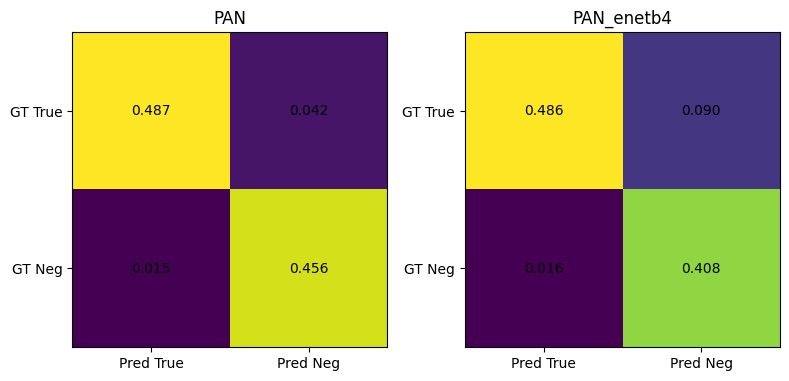

In [ ]:
"""
Calculate and plot the confusion Matrix
"""

def plot_mean_confusion_matrix_per_model(df):
    models = df["model"].unique()
    n_models = len(models)

    fig, axes = plt.subplots(1, n_models, figsize=(4*n_models, 4))

    for ax, model in zip(axes, models):
        d = df[df["model"] == model]

        TP = d["tp"].sum()
        FP = d["fp"].sum()
        FN = d["fn"].sum()
        TN = d["tn"].sum()

        cm = np.array([
            [TP, FP],
            [FN, TN]
        ], dtype=np.float32)

        # normalisieren
        cm = cm / (cm.sum() + 1e-8)

        im = ax.imshow(cm)

        ax.set_title(model)
        ax.set_xticks([0,1])
        ax.set_yticks([0,1])
        ax.set_xticklabels(["Pred True", "Pred Neg"])
        ax.set_yticklabels(["GT True", "GT Neg"])

        # Zahlen einzeichnen
        for i in range(2):
            for j in range(2):
                ax.text(
                    j, i, f"{cm[i,j]:.3f}",
                    ha="center", va="center",
                    color="white" if cm[i,j] > 0.5 else "black"
                )

    plt.tight_layout()
    plt.show()

plot_mean_confusion_matrix_per_model(df)
